# degree_pred_v001
https://www.kaggle.com/t88take/estimating-the-direction-with-a-magnetic-se-e46cec  
の再現

In [1]:
import os
import pandas as pd
import numpy as np
import ipynb_path
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
import plotly
import plotly.express as px
%matplotlib inline
pd.set_option('display.max_rows', 200)
from math import * 
import warnings
warnings.simplefilter('ignore')

In [2]:
def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [3]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=1000,
                            width=2000)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()

In [4]:
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [5]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [6]:
# lowpass filter

from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

order = 3
fs = 50.0
cutoff = 2.5

In [7]:
# Offset correction
# refarence https://github.com/J-ROCKET-BOY/SS-Fitting

def SS_fit(data) : 

    x = data[:,[0]]
    y = data[:,[1]]
    z = data[:,[2]]

    data_len = len(x)
    
    x2 = np.power(x,2)
    y2 = np.power(y,2)
    z2 = np.power(z,2)

    r1 = -x*(x2+y2+z2)
    r2= -y*(x2+y2+z2)
    r3 = -z*(x2+y2+z2)
    r4 = -(x2+y2+z2)

    left = np.array([[np.sum(x2),np.sum(x*y),np.sum(x*z),np.sum(x)],
                     [np.sum(x*y),np.sum(y2),np.sum(y*z),np.sum(y)],
                     [np.sum(x*z),np.sum(y*z),np.sum(z2),np.sum(z)],
                     [np.sum(x), np.sum(y), np.sum(z), data_len]])
    
    right = np.array([np.sum(r1),
                      np.sum(r2),
                      np.sum(r3),
                      np.sum(r4)])
    
    si = np.dot(np.linalg.inv(left),right)

    x0 = (-1/2)* si[0]
    y0 = (-1/2)* si[1]
    z0 = (-1/2)* si[2]
    
    return np.array([x0,y0,z0])

In [8]:
# Vincenty's formulae
# refarence https://qiita.com/r-fuji/items/99ca549b963cedc106ab

def vincenty_inverse(lat1, lon1, lat2, lon2):

    # Not advanced
    if isclose(lat1, lat2) and isclose(lon1, lon2):
        return False
    
    # WGS84
    a = 6378137.0
    ƒ = 1 / 298.257223563
    b = (1 - ƒ) * a

    lat_1 = atan((1 - ƒ) * tan(radians(lat1)))
    lat_2 = atan((1 - ƒ) * tan(radians(lat2)))
    
    lon_diff = radians(lon2) - radians(lon1)
    λ = lon_diff

    for i in range(1000):
        sinλ = sin(λ)
        cosλ = cos(λ)
        sinσ = sqrt((cos(lat_2) * sinλ) ** 2 + (cos(lat_1) * sin(lat_2) - sin(lat_1) * cos(lat_2) * cosλ) ** 2)
        cosσ = sin(lat_1) * sin(lat_2) + cos(lat_1) * cos(lat_2) * cosλ
        σ = atan2(sinσ, cosσ)
        sinα = cos(lat_1) * cos(lat_2) * sinλ / sinσ
        cos2α = 1 - sinα ** 2
        cos2σm = cosσ - 2 * sin(lat_1) * sin(lat_2) / cos2α
        C = ƒ / 16 * cos2α * (4 + ƒ * (4 - 3 * cos2α))
        λʹ = λ
        λ = lon_diff + (1 - C) * ƒ * sinα * (σ + C * sinσ * (cos2σm + C * cosσ * (-1 + 2 * cos2σm ** 2)))
        
        if abs(λ - λʹ) <= 1e-12:
            break
    else:
        return None

    α = atan2(cos(lat_2) * sinλ, cos(lat_1) * sin(lat_2) - sin(lat_1) * cos(lat_2) * cosλ)

    if α < 0:
        α = α + pi * 2

    return degrees(α)

In [9]:
def calc3(row):
    deg = - degrees(atan2(-1*row['calc2'],row['calc1']))
    if deg < 0:
        deg += 360
    return deg 

In [10]:
def calc_degree_by_gt(df):
    phones = df['phone'].unique()
    df['deg'] = np.nan
    
    for idx in range(len(df)-1):
        if df.at[idx, 'phone'] != df.at[idx+1, 'phone']:
            continue
            
        lat = df.at[idx, 'latDeg_gt']
        lng = df.at[idx, 'lngDeg_gt']
        lat_next = df.at[idx+1, 'latDeg_gt']
        lng_next = df.at[idx+1, 'lngDeg_gt']
        
        res = vincenty_inverse(lat, lng, lat_next, lng_next)
        if res:
            df.at[idx, 'deg'] = res
    
    return df

In [11]:
def calc_degree_by_imu(df, accel, mag):
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    accel['phone'] = accel['collectionName'] + '_' + accel['phoneName']
    mag['phone'] = mag['collectionName'] + '_' + mag['phoneName']
    
    # utc -> gps
    accel['millisSinceGpsEpoch'] = accel['utcTimeMillis'] - 315964800000 + 18000
    mag['millisSinceGpsEpoch'] = mag['utcTimeMillis'] - 315964800000 + 18000
    
    # resampling追加
    df['secondSinceGpsEpoch'] = df['millisSinceGpsEpoch'] // 1000
    accel['secondSinceGpsEpoch'] = accel['millisSinceGpsEpoch'] // 1000
    mag['secondSinceGpsEpoch'] = mag['millisSinceGpsEpoch'] // 1000
    
    # clipping
    accel[['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2']] = accel.groupby('phone')['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2'].transform(lambda x: x.clip(x.quantile(0.001), x.quantile(0.999)))
    mag[['UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT']] = mag.groupby('phone')['UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT'].transform(lambda x: x.clip(x.quantile(0.001), x.quantile(0.999)))
    
    #     acce filtering and smooting
    accel["global_x"] = accel["UncalAccelZMps2"]
    accel["global_y"] = accel["UncalAccelXMps2"]
    accel["global_z"] = accel["UncalAccelYMps2"]
    accel["x_f"] = butter_lowpass_filter(accel["global_x"], cutoff, fs, order)
    accel["y_f"] = butter_lowpass_filter(accel["global_y"], cutoff, fs, order)
    accel["z_f"] = butter_lowpass_filter(accel["global_z"], cutoff, fs, order)
    
    mag["global_mx"] = mag["UncalMagZMicroT"]
    mag["global_my"] = mag["UncalMagYMicroT"]
    mag["global_mz"] = mag["UncalMagXMicroT"]

    
    output_df = pd.DataFrame()
    for phone in mag['phone'].unique():
        df_tmp = df[df['phone']==phone]
        accel_tmp = accel[accel['phone']==phone].copy()
        mag_tmp = mag[mag['phone']==phone].copy()
    
        smooth_range = 1000
        accel_tmp["x_f"] = accel_tmp.groupby('phone')["x_f"].rolling(smooth_range, center=True, min_periods=1).mean().values
        accel_tmp["y_f"] = accel_tmp.groupby('phone')["y_f"].rolling(smooth_range, center=True, min_periods=1).mean().values
        accel_tmp["z_f"] = accel_tmp.groupby('phone')["z_f"].rolling(smooth_range, center=True, min_periods=1).mean().values

        mag_tmp["global_mx"] = mag_tmp.groupby('phone')["global_mx"].rolling(smooth_range,  min_periods=1).mean().values
        mag_tmp["global_my"] = mag_tmp.groupby('phone')["global_mz"].rolling(smooth_range,  min_periods=1).mean().values
        mag_tmp["global_mz"] = mag_tmp.groupby('phone')["global_my"].rolling(smooth_range,  min_periods=1).mean().values

        offset = SS_fit(np.array(mag_tmp[["global_mx","global_my","global_mz"]]))
        mag_tmp["global_mx"] = (mag_tmp["global_mx"] - offset[0])*-1
        mag_tmp["global_my"] = mag_tmp["global_my"] - offset[1]
        mag_tmp["global_mz"] = mag_tmp["global_mz"] - offset[2]
        
        accel_tmp = accel_tmp.groupby(['phone', 'secondSinceGpsEpoch'])['x_f', 'y_f', 'z_f'].mean().reset_index()
        accel_tmp.columns = ['phone', 'secondSinceGpsEpoch', 'x_f', 'y_f', 'z_f']
    
        mag_tmp = mag_tmp.groupby(['phone', 'secondSinceGpsEpoch'])['global_mx', 'global_my', 'global_mz'].mean().reset_index()
        mag_tmp.columns = ['phone', 'secondSinceGpsEpoch', 'global_mx', 'global_my', 'global_mz']    

        df_tmp = df_tmp.merge(accel_tmp, on=['phone', 'secondSinceGpsEpoch'], how='left')
        df_tmp = df_tmp.merge(mag_tmp, on=['phone', 'secondSinceGpsEpoch'], how='left')
        
        start_mean_range = 10
        x_start_mean = df_tmp[:start_mean_range]["x_f"].mean()
        y_start_mean = df_tmp[:start_mean_range]["y_f"].mean()
        z_start_mean = df_tmp[:start_mean_range]["z_f"].mean() 

        #     roll and picth, device tilt
        r = atan(y_start_mean/z_start_mean)
        p = atan(x_start_mean/(y_start_mean**2 + z_start_mean**2)**0.5)

    #     calculation　degrees

        df_tmp["calc1"] = df_tmp["global_mx"]*cos(p) + df_tmp["global_my"]*sin(r)*sin(p) + df_tmp["global_mz"]*sin(p)*cos(r)
        df_tmp["calc2"] = df_tmp["global_mz"]*sin(r) - df_tmp["global_my"]*cos(r)
        df_tmp["calc_deg"] = df_tmp.apply(calc3, axis=1)
        output_df = output_df.append(df_tmp)
    return output_df

In [12]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/prep/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# データ読み込み

In [13]:
accel_train = pd.read_csv(INPUT + '/prep/gnss/train/UncalAccel.csv')
mag_train = pd.read_csv(INPUT + '/prep/gnss/train/UncalMag.csv')
accel_test = pd.read_csv(INPUT + '/prep/gnss/test/UncalAccel.csv')
mag_test = pd.read_csv(INPUT + '/prep/gnss/test/UncalMag.csv')
train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
ground_truth = pd.read_csv(INPUT + '/prep/ground_truth_train.csv')

ground_truth = ground_truth.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
gt = ground_truth[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg_gt', 'lngDeg_gt', 'speedMps', 'courseDegree']].copy()
train = train.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')

# IMUからdegを算出

In [14]:
train = calc_degree_by_imu(train, accel_train, mag_train)
test = calc_degree_by_imu(test, accel_test, mag_test)

# 座標移動からdegを算出

In [15]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train = calc_degree_by_gt(train)

In [16]:
train[['collectionName', 'phoneName', 'phone', 'millisSinceGpsEpoch', 'calc_deg']].to_csv(OUTPUT + '/train_degree_pred.csv', index=False)
test[['collectionName', 'phoneName', 'phone', 'millisSinceGpsEpoch', 'calc_deg']].to_csv(OUTPUT + '/test_degree_pred.csv', index=False)

# 可視化・評価

In [17]:
output_dir = OUTPUT + '/train/degree_compare'
os.makedirs(output_dir, exist_ok=True)

for phone in train['phone'].unique():

    fig, axes = plt.subplots(figsize=(5*3, 20), nrows=2,sharex=True)
    tmp = train[train['phone']==phone].copy()
    
    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['courseDegree'], label='courseDegree')
    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['calc_deg'], label='pred')
    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['deg'], label='gt')
    axes[0].legend(loc='upper right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)

    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['global_mx'], label='global_mx')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['global_my'], label='global_my')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['global_mz'], label='global_mz')
    axes[1].legend(loc='upper right')
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)

    fig.suptitle(phone, fontsize=16)
    fig.savefig(output_dir + '/' + phone + '.png')
    plt.close()

In [18]:
output_dir = OUTPUT + '/test/degree_compare'
os.makedirs(output_dir, exist_ok=True)

for phone in test['phone'].unique():

    fig, axes = plt.subplots(figsize=(5*3, 20), nrows=2,sharex=True)
    tmp = test[test['phone']==phone].copy()
    
    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['calc_deg'], label='pred')
    axes[0].legend(loc='upper right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)

    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['global_mx'], label='global_mx')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['global_my'], label='global_my')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['global_mz'], label='global_mz')
    axes[1].legend(loc='upper right')
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)

    fig.suptitle(phone, fontsize=16)
    fig.savefig(output_dir + '/' + phone + '.png')
    plt.close()

In [19]:
from sklearn.metrics import mean_squared_error
train2 = train.dropna(subset=['deg', 'calc_deg'])
print('total : ', np.sqrt(mean_squared_error(train2['deg'], train2['calc_deg'])))
phones = train2['phone'].unique()
for phone in phones:
    tmp = train2[train2['phone']==phone].copy()
    print(phone + ' : ', np.sqrt(mean_squared_error(tmp['deg'], tmp['calc_deg'])))

total :  74.97877168220556
2020-05-21-US-MTV-2_Pixel4 :  56.257028648494824
2020-05-21-US-MTV-2_Pixel4XL :  52.38863608565278
2020-06-11-US-MTV-1_Pixel4 :  54.97242721019269
2020-06-11-US-MTV-1_Pixel4XL :  41.46518390151724
2020-06-05-US-MTV-2_Pixel4 :  86.48088674919133
2020-06-05-US-MTV-2_Pixel4XL :  77.33414853267792
2020-07-17-US-MTV-1_Mi8 :  85.51693557754521
2021-04-22-US-SJC-1_Pixel4 :  58.10376638674484
2021-04-22-US-SJC-1_SamsungS20Ultra :  59.55531597700812
2020-05-14-US-MTV-2_Pixel4 :  41.338144735812236
2020-05-14-US-MTV-2_Pixel4XLModded :  167.85217322663894
2021-01-05-US-SVL-1_Pixel5 :  119.47426700586193
2021-01-05-US-SVL-1_Pixel4 :  119.19152942862478
2021-01-05-US-SVL-1_Pixel4XL :  116.1702470634143
2021-01-05-US-SVL-1_Mi8 :  73.34380620215498
2020-06-04-US-MTV-1_Pixel4 :  35.10194409186229
2020-06-04-US-MTV-1_Pixel4XL :  21.63231690409659
2020-06-04-US-MTV-1_Pixel4XLModded :  190.53490721412905
2021-01-05-US-SVL-2_Pixel4Modded :  120.2276427530859
2021-01-05-US-SVL-2_

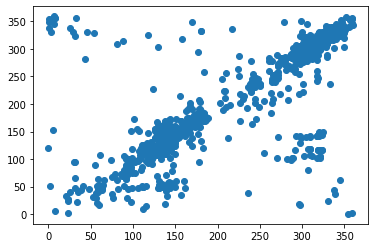

In [20]:
tmp = train2.sample(1000)
plt.scatter(tmp['deg'], tmp['calc_deg'])